In [ ]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

colors = sns.color_palette()
color1=colors[8]
color2=colors[0]
color3=colors[2]
color4= colors[4]
odor_list_color = [color1, color2, color3, color4]

color_dict_label = {'NO ODOR': color1, 'NULL': color1, 'ODOR_A': color2, 'ODOR_B': color3, 'ODOR_C': color4}

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'
data_path = r'C:\git\Aind.Behavior.VrForaging.Analysis\data'
foraging_figures = r'C:\git\Aind.Behavior.VrForaging.Analysis\results\\novelty_experiment'

from scipy.optimize import curve_fit


In [ ]:
mouse_list = ['717716','717717', '745306', '745305', '745300', '745301']

In [ ]:
summary_df = pd.DataFrame()
all_epochs = pd.DataFrame()
within_session_n = 0
experiment = 0
for mouse in mouse_list:
    print(mouse)
    session_n = 0
    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)
    
    with PdfPages(os.path.join(foraging_figures, f'{mouse}_velocity_traces_novelty.pdf')) as pdf:
        for file_name in sorted_files:
            session_path = os.path.join(base_path, mouse, file_name)
            session = file_name[7:15]
            print(session)

            session_path = Path(session_path)

            try:
                data = parse.load_session_data(session_path)
            except:
                print('Error loading session')
                continue
            
            # Parse data
            reward_sites, active_site, config = parse.parse_dataframe(data)
            
            if reward_sites.empty:      
                session_n += 1
                continue
            
            reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
            active_site = AddExtraColumns(reward_sites, active_site, run_on_init=True).add_time_previous_intersite_interpatch()
            encoder_data = parse.ContinuousData(data).encoder_data

            # trial_summary = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites']], encoder_data, mouse, session, window=(-1,3))
            # plotting.velocity_traces_odor_entry(trial_summary, 
            #                                     max_range=max(trial_summary.speed.values), 
            #                                     color_dict_label=color_dict_label, 
            #                                     mean=True, 
            #                                     save=pdf, 
            #                                     mouse=mouse, 
            #                                     session=session)

            active_site['next_intersite'] = active_site.index.to_series().shift(-1)
            active_site['time_in_site'] = active_site.next_intersite - active_site.index
            active_site['mouse'] = mouse
            active_site['session'] = session
            active_site['session_n'] = session_n
            active_site['session_type'] = data['config'].streams.tasklogic_input.data['stage_name']
            active_site['distance_in_session'] = active_site['length'].shift(1).cumsum()/100
            active_site['time_in_session'] = active_site['time_in_site'].shift(1).cumsum()

            session_n += 1

            active_site = active_site[['label', 'start_position', 'length', 'active_patch','odor_label','odor_sites','total_sites', 'previous_interpatch',
                'previous_intersite', 'same_patch', 'time_in_site', 'mouse', 'session', 'session_n', 'session_type','time_in_session', 'distance_in_session']]
            
            summary_df = pd.concat([summary_df, active_site])


In [ ]:
summary_df['experimental_round'] = 1
summary_df.loc[(summary_df['mouse'] == '717716') & (summary_df['session'].astype(int)> 20240729),'experimental_round'] = 2
summary_df.loc[(summary_df['mouse'] == '745305') & (summary_df['session'].astype(int)> 20240729),'experimental_round'] = 2

# Find the biggest session_n for session type session_0 for each mouse
summary_df['max_session_n_session_0'] = summary_df[summary_df['session_type'] == 'session_0'].groupby('mouse')['session_n'].transform('max')

summary_df['odor_label'] = np.where(summary_df['odor_label'] == 'NULL', 'NO ODOR', summary_df['odor_label'])
summary_df.to_csv(os.path.join(data_path, 'novelty_df.csv'), index=False, na_rep='NULL')

In [ ]:
summary_df.odor_label.unique()

### Explore plots

In [330]:
summary_df = pd.read_csv(os.path.join(data_path, 'novelty_df.csv'), na_values=[])

In [331]:
summary_df = summary_df[summary_df['label'] == 'RewardSite']
# summary_df= summary_df[summary_df['time_in_site'] < 15]

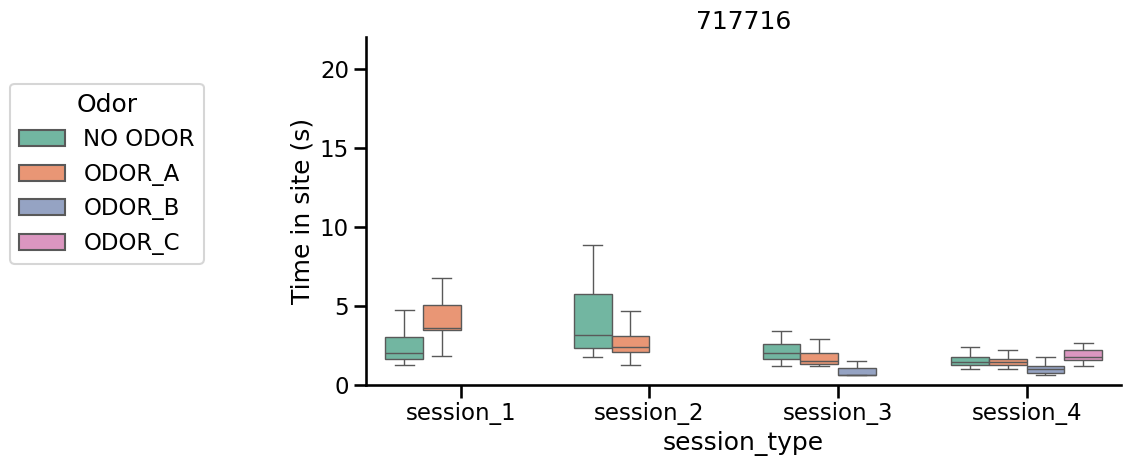

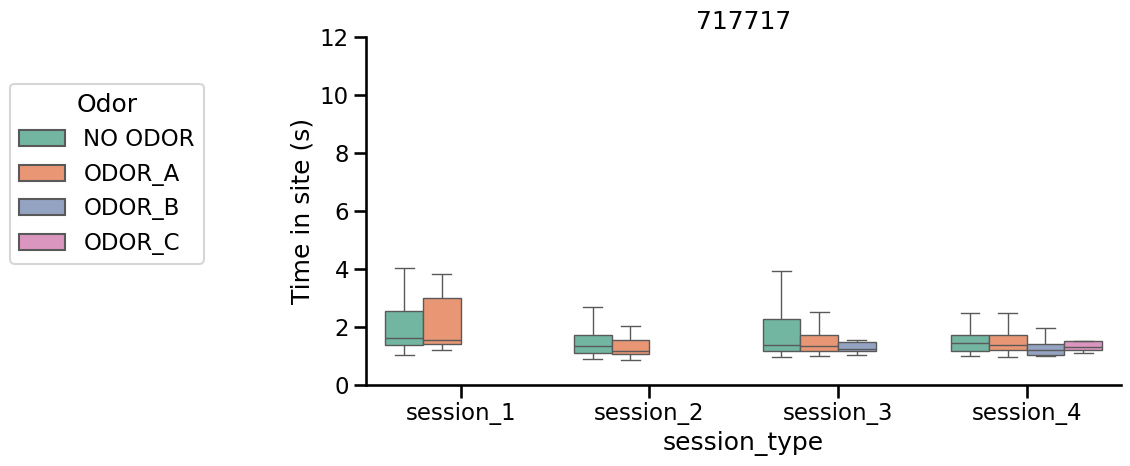

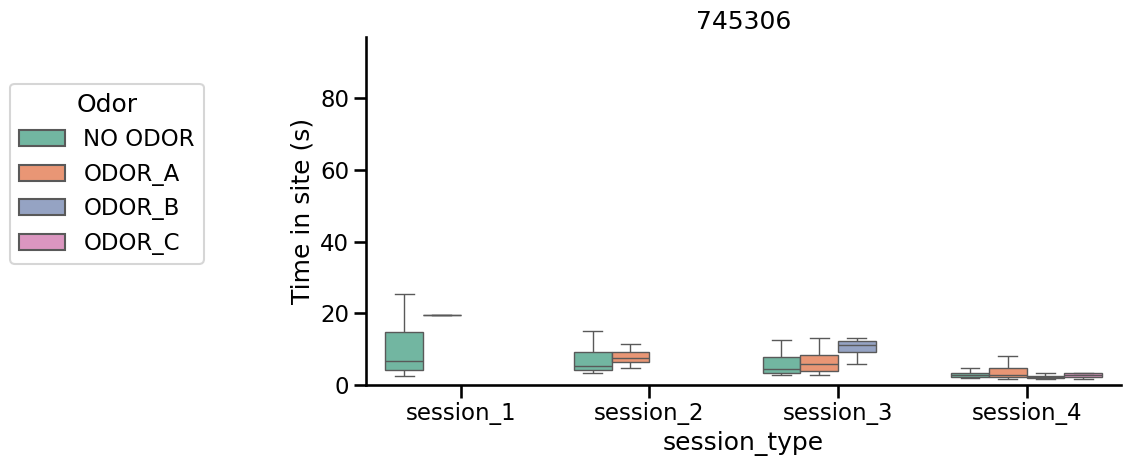

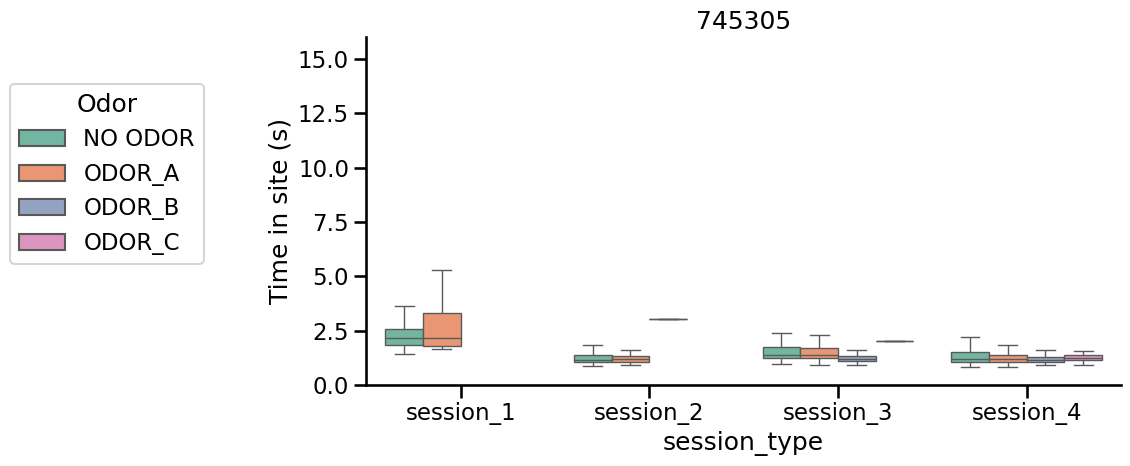

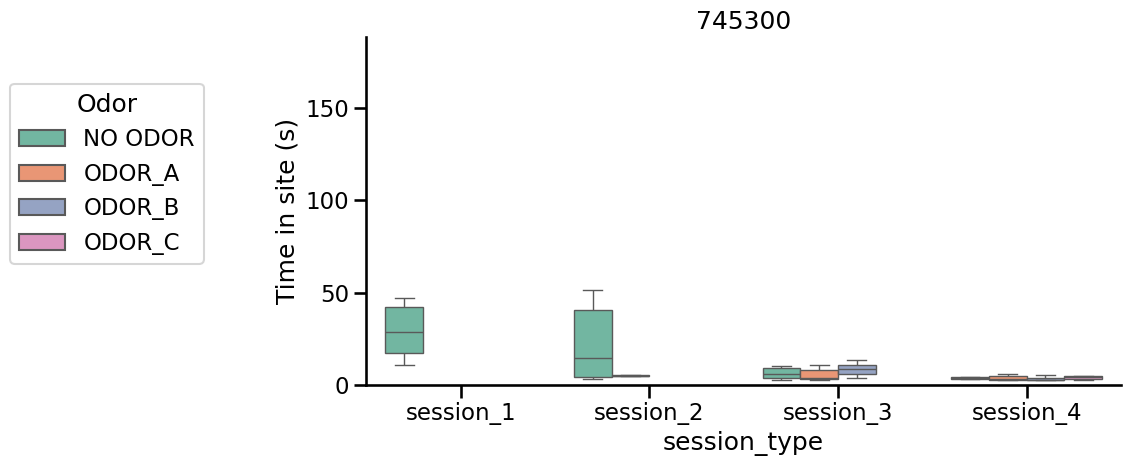

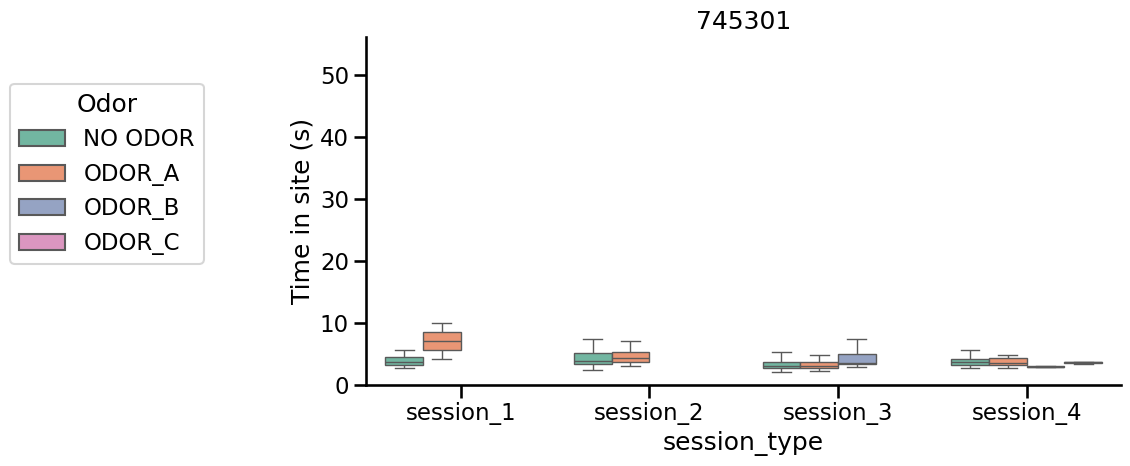

In [332]:
with PdfPages(os.path.join(foraging_figures, f'novelty_time_in_site.pdf')) as pdf:
    for mouse in summary_df.mouse.unique():
        fig = plt.figure(figsize=(12, 5))
        sns.boxplot(x='session_type', y='time_in_site', data=summary_df[(summary_df.mouse==mouse)&(summary_df.session_type != 'session_0')&(summary_df.experimental_round == 1)], 
                    hue='odor_label', palette='Set2', dodge=True, hue_order= ['NO ODOR', 'ODOR_A', 'ODOR_B', 'ODOR_C'], fliersize=0)

        plt.ylabel('Time in site (s)')
        plt.title(f'{mouse}')
        plt.legend(bbox_to_anchor = (-0.2, 0.9), title='Odor', loc='upper right')
        plt.ylim(0, int(summary_df[summary_df.mouse==mouse].time_in_site.quantile(0.99)))
        plt.tight_layout()
        sns.despine()
        plt.show()
        pdf.savefig(fig)

In [ ]:
# Run some t tests
stats_df = summary_df[(summary_df.experimental_round == 1)].groupby(['session_type', 'mouse', 'odor_label']).time_in_site.mean().reset_index()
pre = summary_df[(stats_df.session_type == 'session_1')&(stats_df.odor_label == 'NULL')].time_in_site

post = summary_df[(stats_df.session_type == 'session_1')&(summary_df.odor_label == 'ODOR_A')].time_in_site
stats.ttest_ind(pre, post)

##### Distance in session for the time in session across several mice

In [ ]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='time_in_session', y='distance_in_session', data=summary_df[(summary_df.session_type == 'session_1')], hue='mouse', palette='Set2', ci=None)
plt.title(f'Habituation session {session}')
plt.xlabel('Time in session (s)')
plt.ylabel('Distance travelled (m)')
plt.tight_layout()
sns.despine()
plt.show()
fig.savefig(os.path.join(foraging_figures, f'session_1_distance_travelled.svg'))

In [ ]:
for session in summary_df[(summary_df.session_type == 'session_0')].session_n.unique():
    fig = plt.figure(figsize=(10, 5))
    sns.lineplot(x='time_in_session', y='distance_in_session', data=summary_df[(summary_df.session_n==session)&(summary_df.session_type == 'session_0')], marker = 'o', hue='mouse', palette='Set2', ci=None)
    plt.title(f'Habituation session {session}')
    plt.xlabel('Time in session (s)')
    plt.ylabel('Distance travelled (m)')
    plt.tight_layout()
    sns.despine()
    plt.show()
    fig.savefig(os.path.join(foraging_figures, f'{session}_distance_travelled.svg'))

In [ ]:
summary_df['last_session'] = np.where(summary_df['session_n'] == summary_df['max_session_n_session_0'], 1, 0)

fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='time_in_session', y='distance_in_session', data=summary_df[(summary_df.last_session==1)], hue='mouse', palette='Set2', ci=None)
plt.title(f'{session}')
plt.xlabel('Time in session (s)')
plt.ylabel('Distance travelled (m)')
plt.title('Last habituating session')
plt.tight_layout()
sns.despine()
plt.show()
fig.savefig(os.path.join(foraging_figures, 'last_habituating_session.svg'), dpi=300)

##### Distance in session for the time in session across several sessions

In [ ]:
for mouse in summary_df.mouse.unique():
    fig = plt.figure(figsize=(10, 6))
    sns.lineplot(x='time_in_session', y='distance_in_session', hue='session_n', data=summary_df[(summary_df.mouse==mouse)&(summary_df.session_type == 'session_0')],  palette='Set2', marker= 'o', ci=None)
    plt.title(f'{mouse}')
    plt.xlabel('Time in session (s)')
    plt.ylabel('Distance travelled (m)')
    plt.tight_layout()
    sns.despine()
    plt.show()
    fig.savefig(os.path.join(foraging_figures, f'across_sessions_mouse_{mouse}.svg'), dpi=300)